## This notebook selects the 12 best contours and saves their data as indvidiual watershed csv
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html

In [49]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [2]:
# dependencies
import pandas as pd
import scipy.interpolate as sci_int
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import cartopy.crs as ccrs
import geopandas as gpd

import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.lines as mlines


from sklearn.preprocessing import MinMaxScaler
import hdbscan

from joblib import Parallel, delayed
from fast_histogram import histogram2d

In [3]:
# import undrogued data
beach = pd.read_csv('undrogued_beach.csv')
unbeach = pd.read_csv('undrogued_unbeach.csv')

In [4]:
# Set the random seed
random_seed = 42
np.random.seed(random_seed)

In [5]:
# get features for clustering and normalize to close to scale of lat/lon with lat/lon weighted for clustering AND RUN HDBSCAN TWICE
# get beach points for beach lat/lon
last_points_input = beach.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon))#, time_normalized, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 40, # minimum number beach points in a cluster
    cluster_selection_epsilon = 8,# clusters below distance threshold are merged
    cluster_selection_method = 'leaf') 
hdb.fit(cluster_input)
labels = hdb.labels_

#organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 0:
        cluster_ids.append(count)
    count += 1

# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), beach_clusters_select.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(beach_clusters_select['id'])]

In [6]:
len(beach_clusters.drop_duplicates(subset='id', keep='last'))

3585

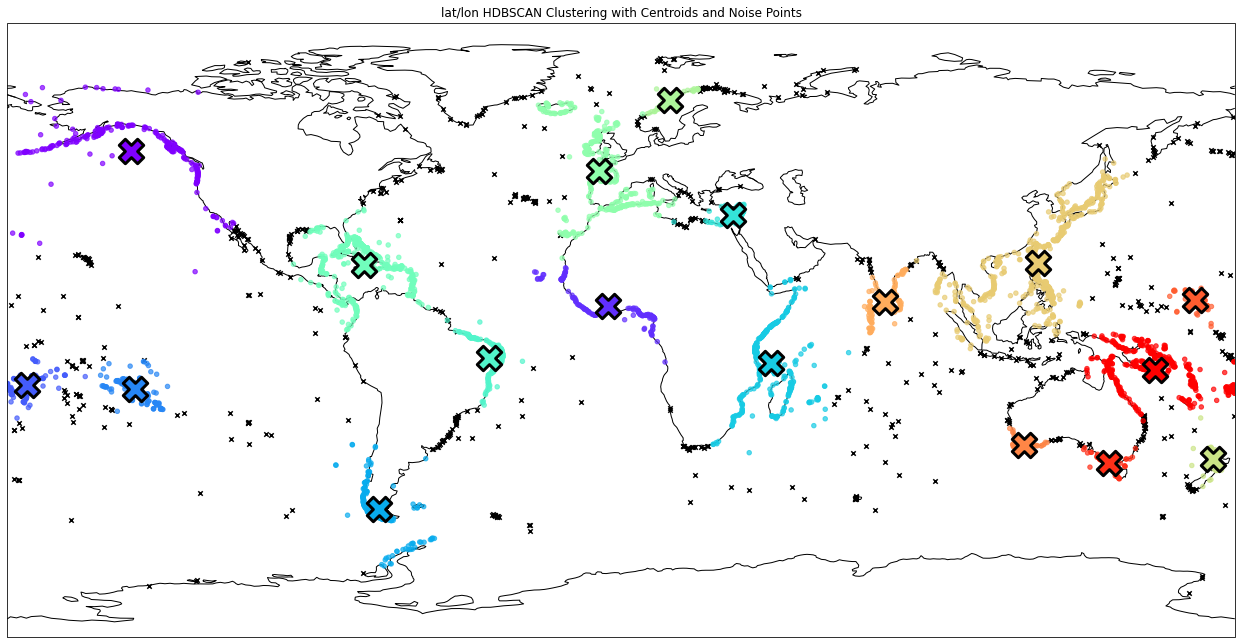

In [7]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

# Plot noise points as small 'x'
noise_mask = (labels == -1)
ax.scatter(cluster_input[noise_mask, 1], cluster_input[noise_mask, 0], marker='x', color='black', s=20, label='Noise Points')

# Scatter plot with colors based on HDBSCAN labels
scatter1 = plt.scatter(
    cluster_input[labels != -1, 1],
    cluster_input[labels != -1, 0],
    marker='o',
    c=labels[labels != -1],
    cmap='rainbow',
    alpha=0.7,
    s=20
)

# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id != -1:
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')

# Get the colors used in the first figure
colors_first_figure = scatter1.to_rgba(scatter1.get_array())

#ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('lat/lon HDBSCAN Clustering with Centroids and Noise Points')
plt.show()

In [8]:
# NOW INPUT CLUSTERED DATA INTO NEW HDBSCAN
# get beach points for beach lat/lon
last_points_input = beach_clusters.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon))#, time_normalized, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 10, # minimum number beach points in a cluster
    cluster_selection_epsilon = 2) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

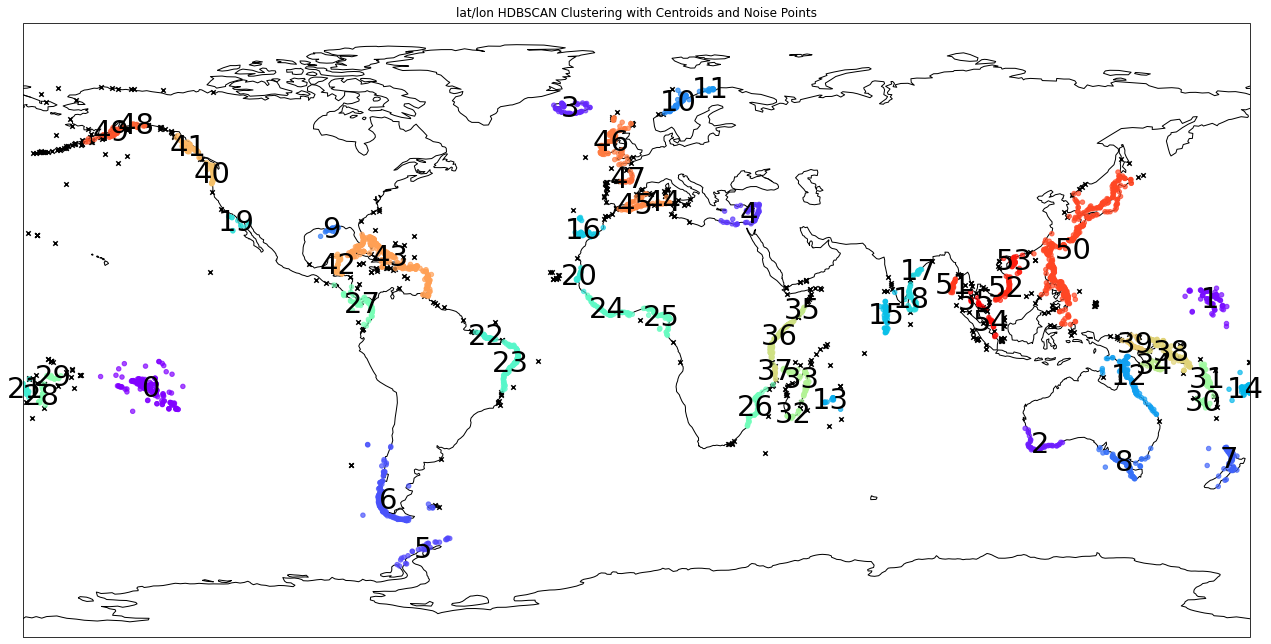

In [9]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

# Plot noise points as small 'x'
noise_mask = (labels == -1)
ax.scatter(cluster_input[noise_mask, 1], cluster_input[noise_mask, 0], marker='x', color='black', s=20, label='Noise Points')

# Scatter plot with colors based on HDBSCAN labels
scatter1 = plt.scatter(
    cluster_input[labels != -1, 1],
    cluster_input[labels != -1, 0],
    marker='o',
    c=labels[labels != -1],
    cmap='rainbow',
    alpha=0.7,
    s=20
)

# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id != -1:
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
       # ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')
        # plot label 
        ax.text(centroid[1], centroid[0], str(cluster_id), fontsize=29, ha='center', va='center', color='black')
        
# Get the colors used in the first figure
colors_first_figure = scatter1.to_rgba(scatter1.get_array())

#ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('lat/lon HDBSCAN Clustering with Centroids and Noise Points')
plt.show()

In [10]:
# let's collect clusters into larger clusters, then filter by number of points

# organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 0:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

def get_cluster_ids(cluster_ids,dataframe):
    ids = []
    for cluster in cluster_ids:
        ids.extend(np.array([id for id in dataframe['id'].where(dataframe['HDBSCAN'] == cluster).dropna()]))
    return ids
watersheds={
    'PNW': get_cluster_ids([49, 48, 41,40],beach_clusters_select),
    'Asia': get_cluster_ids([50,1,53,52,55,54],beach_clusters_select),
    'Oceania': get_cluster_ids([39, 38, 31, 34,12,30,14],beach_clusters_select),
    'India': get_cluster_ids([17,15,18,15,51],beach_clusters_select),
    'E_Africa': get_cluster_ids([35, 36, 37, 33,26,32,13],beach_clusters_select),
    'W_Africa': get_cluster_ids([24, 25,20],beach_clusters_select),
    'Europe': get_cluster_ids([47, 46,3, 10, 11,16],beach_clusters_select),
    'Caribbean': get_cluster_ids([42, 43, 9],beach_clusters_select),
    'Australia': get_cluster_ids([7, 8,2],beach_clusters_select),
    'Equatorial_Pacific': get_cluster_ids([21, 29, 28,0],beach_clusters_select),
    'Brazil': get_cluster_ids([22, 23],beach_clusters_select),
    'Chile': get_cluster_ids([6, 5],beach_clusters_select)}



In [11]:
for watershed in watersheds:
    print(len(watersheds[str(watershed)]))

143
602
353
150
272
139
255
356
162
231
146
161


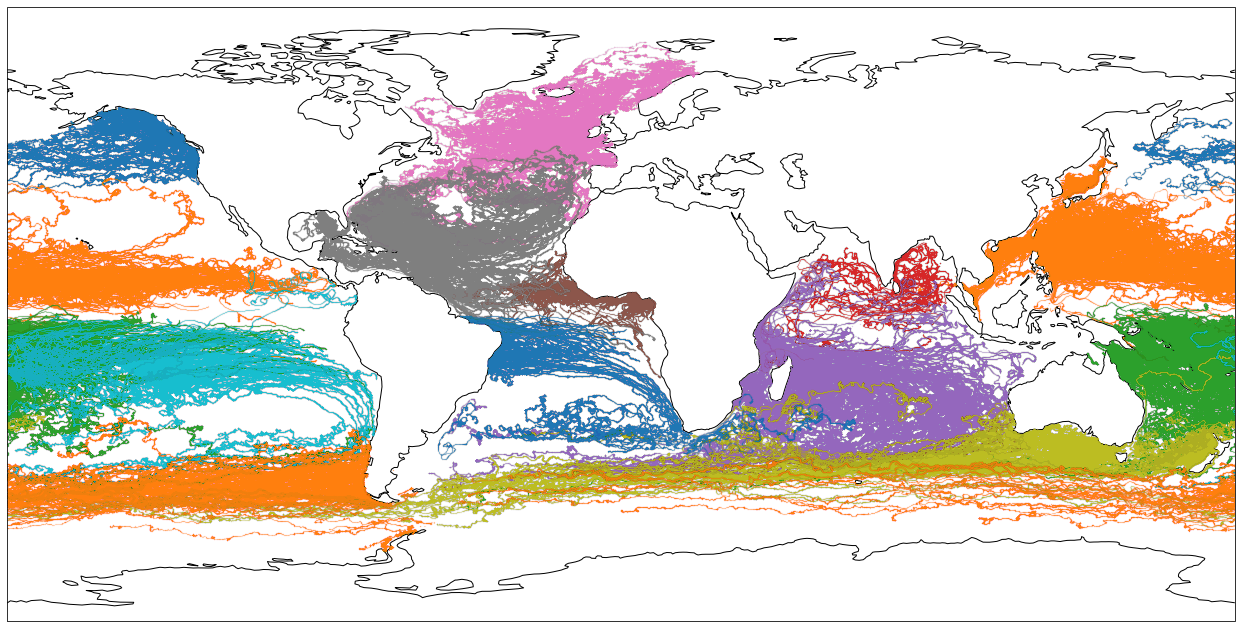

In [12]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

# Plot noise points as small 'x'
#noise_mask = (labels == -1)
#ax.scatter(cluster_input[noise_mask, 1], cluster_input[noise_mask, 0], marker='x', color='black', s=20, label='Noise Points')

# Scatter plot with colors based on HDBSCAN labels
for watershed in watersheds:
    scatter1 = plt.scatter(
        beach[beach['id'].isin(watersheds[str(watershed)])]['lon'],
        beach[beach['id'].isin(watersheds[str(watershed)])]['lat'],
        marker='o',
      #  c=labels[labels != -1],
        cmap='rainbow',
        alpha=0.7,
        s=0.001
    )

# Plot centroids with the same colors as corresponding points
#for cluster_id in set(labels):
#    cluster_mask = (labels == cluster_id)#

#    if cluster_id != -1:
#        cluster_points = cluster_input[cluster_mask]
#        centroid = np.mean(cluster_points, axis=0)
#        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
#       # ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')
#        # plot label 
#        ax.text(centroid[1], centroid[0], str(cluster_id), fontsize=29, ha='center', va='center', color='black')
        
# Get the colors used in the first figure
colors_first_figure = scatter1.to_rgba(scatter1.get_array())

#ax.legend()
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.title('selected clusters')
plt.show()

In [13]:
# Load world shapefile once
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

# Define the grid for the heatmap
n_lons, n_lats = 135, 85  # Number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)
lon_centers_cluster = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers_cluster = (lat_bins[1:] + lat_bins[:-1]) / 2
def process_watersheds(watershed_names, watersheds):
    # Create a figure for the plot
    fig = plt.figure(figsize=(22, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

    cmap = plt.cm.get_cmap("viridis").copy()

    # Initialize heatmap storage
    heatmaps = {period: np.zeros((n_lats, n_lons)) for period in ['full', '12m', '6m', '3m', '1m']}

    for watershed_name in watershed_names:
        ids = watersheds[watershed_name]
        # Filter data for the watershed
        mask = beach['id'].isin(ids)
        filtered_watershed_data = beach[mask]

        # Calculate the latest_time for the current watershed
        latest_time = filtered_watershed_data['time_to_beach'].max()

        # Define time thresholds based on the latest_time for the current watershed
        time_thresholds = {
            'full': latest_time - 1555200000000000000,  # Full time range
            '12m': latest_time - 31536000,         # 12 months
            '6m': latest_time - 15552000,          # 6 months
            '3m': latest_time - 7890000,           # 3 months
            '1m': latest_time - 2629800            # 1 month
        }

        # Collect latitude and longitude data for the heatmaps
        latitudes, longitudes = {}, {}
        for period, start_time in time_thresholds.items():
            period_filtered_data = filtered_watershed_data[filtered_watershed_data['time_to_beach'] >= start_time]
            latitudes[period] = period_filtered_data['lat'].values
            longitudes[period] = period_filtered_data['lon'].values

            # Update heatmaps with the watershed data
            heatmap_data = histogram2d(latitudes[period], longitudes[period], bins=[n_lats, n_lons], range=[[-90, 90], [-180, 180]])
            heatmaps[period] += heatmap_data

    # Normalize the data to be in the range [0, 1]
    for period in heatmaps.keys():
        heatmaps[period] = (heatmaps[period] - np.min(heatmaps[period])) / (np.max(heatmaps[period]) - np.min(heatmaps[period]))

    # Define linestyles for each watershed
    linestyle_list = ['solid', 'dashed', 'dotted']
    
    # List to store contour handles for the legend
    contour_handles = []

    for j, watershed_name in enumerate(watershed_names):
        # Plot contour lines for the watershed
        contour = ax.contour(lon_centers_cluster, lat_centers_cluster, heatmaps['full'], levels=[0.05], 
                             colors='white', linestyles=linestyle_list[j], 
                             linewidths=2.5, transform=ccrs.PlateCarree())
        # Store contour handles for the legend (uncomment if needed)
        # contour_handles.append(contour.collections[0])

    # Plot the filled contour for normalized heatmap (full time range)
    mesh = ax.pcolormesh(lon_centers_cluster, lat_centers_cluster, heatmaps['full'], cmap=cmap, transform=ccrs.PlateCarree())

    # Plot the land polygons
    land.plot(ax=ax, color='white', edgecolor='none')
    Antarctica.plot(ax=ax, color='white', edgecolor='none')

    # Add colorbar with increased tick size and label text size
    cbar = plt.colorbar(mesh, label='Normalized Point Density')
    cbar.ax.tick_params(labelsize=18)  # Increase tick size
    cbar.set_label('Normalized Point Density', size=20)  # Increase label text size
    ax.set_aspect('auto')

    # Add a legend for the watersheds (using contour handles, uncomment if needed)
    # ax.legend(contour_handles, watershed_names, title="Watersheds", loc='upper left')

    # Title and save figure (uncomment if needed)
    # plt.title(f'Watersheds: {", ".join(watershed_names)}')
    # plt.savefig(f"watersheds_{'_'.join(watershed_names)}.png")
    # plt.close(fig)


In [14]:
os.chdir('/home/openonic/global-drifter-program/')

In [15]:
beach

,id,time,lat,lon,ve,vn,time_to_beach
0,101509,1331078400,13.71750,124.71663,-0.1732,-0.0036,0.0
1,101510,1328140800,22.43137,120.45541,-0.0319,0.1226,363600.0
2,101510,1328144400,22.43232,120.45519,0.0035,-0.0570,360000.0
3,101510,1328148000,22.43020,120.45683,0.0063,-0.0559,356400.0
4,101510,1328151600,22.42962,120.45589,-0.0026,-0.0207,352800.0
...,...,...,...,...,...,...,...
23068316,99237,1276009200,35.62552,-121.83168,0.4754,-0.4431,14400.0
23068317,99237,1276012800,35.61114,-121.81313,0.4754,-0.4434,10800.0
23068318,99237,1276016400,35.59663,-121.79575,0.4548,-0.4522,7200.0
23068319,99237,1276020000,35.58199,-121.77910,0.4310,-0.4501,3600.0


In [16]:
beaching_points = beach.loc[beach.groupby('id')['time_to_beach'].idxmin()]


In [17]:
beaching_coooords = (np.array(beaching_points['lat']),np.array(beaching_points['lon']))

In [ ]:
PNW = beaching_points[beaching_points['id'].isin(watersheds['PNW'])][['lat', 'lon']]
India = beaching_points[beaching_points['id'].isin(watersheds['India'])][['lat', 'lon']]
W_Africa = beaching_points[beaching_points['id'].isin(watersheds['W_Africa'])][['lat', 'lon']]
Australia = beaching_points[beaching_points['id'].isin(watersheds['Australia'])][['lat', 'lon']]
Asia = beaching_points[beaching_points['id'].isin(watersheds['Asia'])][['lat', 'lon']]
Caribbean = beaching_points[beaching_points['id'].isin(watersheds['Caribbean'])][['lat', 'lon']]
Equatorial_Pacific = beaching_points[beaching_points['id'].isin(watersheds['Equatorial_Pacific'])][['lat', 'lon']]
E_Africa = beaching_points[beaching_points['id'].isin(watersheds['E_Africa'])][['lat', 'lon']]
Oceania = beaching_points[beaching_points['id'].isin(watersheds['Oceania'])][['lat', 'lon']]
Brazil = beaching_points[beaching_points['id'].isin(watersheds['Brazil'])][['lat', 'lon']]
Chile = beaching_points[beaching_points['id'].isin(watersheds['Chile'])][['lat', 'lon']]
Europe = beaching_points[beaching_points['id'].isin(watersheds['Europe'])][['lat', 'lon']]

In [19]:
def centroid(watershed):
    lats_center = np.mean(watershed['lat'])
    lons_center = np.mean(watershed['lon'])
    return (lats_center, lons_center)

In [20]:
PNW_centroid = centroid(PNW) 
India_centroid = centroid(India) 
W_Africa_centroid = centroid(W_Africa)
Australia_centroid = centroid(Australia) 
Asia_centroid = centroid(Asia) 
Caribbean_centroid = centroid(Caribbean)
Equatorial_Pacific_centroid = centroid(Equatorial_Pacific) 
E_Africa_centroid = centroid(E_Africa) 
Oceania_centroid = centroid(Oceania)
Brazil_centroid = centroid(Brazil)
Chile_centroid = centroid(Chile)
Europe_centroid = centroid(Europe)

In [21]:
beach

,id,time,lat,lon,ve,vn,time_to_beach
0,101509,1331078400,13.71750,124.71663,-0.1732,-0.0036,0.0
1,101510,1328140800,22.43137,120.45541,-0.0319,0.1226,363600.0
2,101510,1328144400,22.43232,120.45519,0.0035,-0.0570,360000.0
3,101510,1328148000,22.43020,120.45683,0.0063,-0.0559,356400.0
4,101510,1328151600,22.42962,120.45589,-0.0026,-0.0207,352800.0
...,...,...,...,...,...,...,...
23068316,99237,1276009200,35.62552,-121.83168,0.4754,-0.4431,14400.0
23068317,99237,1276012800,35.61114,-121.81313,0.4754,-0.4434,10800.0
23068318,99237,1276016400,35.59663,-121.79575,0.4548,-0.4522,7200.0
23068319,99237,1276020000,35.58199,-121.77910,0.4310,-0.4501,3600.0


In [ ]:
beaching_dict = {
    'PNW': PNW,
    'India': India,
    'W_Africa': W_Africa,
    'Australia': Australia,
    'Asia': Asia,
    'Caribbean': Caribbean,
    'Equatorial_Pacific': Equatorial_Pacific,
    'E_Africa': E_Africa,
    'Oceania': Oceania,
    'Brazil': Brazil,
    'Chile': Chile,
    'Europe': Europe
}

In [23]:
centroid_dict = {
    'PNW': PNW_centroid,
    'India': India_centroid,
    'W_Africa': W_Africa_centroid,
    'Australia': Australia_centroid,
    'Asia': Asia_centroid,
    'Caribbean': Caribbean_centroid,
    'Equatorial_Pacific': Equatorial_Pacific_centroid,
    'E_Africa': E_Africa_centroid,
    'Oceania': Oceania_centroid,
    'Brazil': Brazil_centroid,
    'Chile': Chile_centroid,
    'Europe': Europe_centroid
}

In [24]:
centroid_dict

{'PNW': (53.499427342657334, -137.4473823776225),
 'India': (8.567247102803737, 79.72656607476635),
 'W_Africa': (6.591116690647479, -2.747436834532374),
 'Australia': (-37.34967290123457, 146.88767864197536),
 'Asia': (20.109046112956825, 129.01474906976753),
 'Caribbean': (21.16305893258426, -74.48243587078645),
 'Equatorial_Pacific': (-17.26579095238094, -153.58165956709965),
 'E_Africa': (-10.418899558823526, 43.3386380882353),
 'Oceania': (-11.87457875354107, 156.58729929178472),
 'Brazil': (-8.0876602739726, -38.524937808219185),
 'Chile': (-52.63800658385093, -70.98986795031055),
 'Europe': (54.835702901960794, -6.4079433725490205)}

In [60]:
os.chdir('/home/openonic/global-drifter-program/')
Asia_coords = pd.read_csv('final_watersheds/Asia_coords.csv')
Australia_coords = pd.read_csv('final_watersheds/Australia_coords.csv')
Brazil_coords = pd.read_csv('final_watersheds/Brazil_coords.csv')
Caribbean_coords = pd.read_csv('final_watersheds/Caribbean_coords.csv')
Chile_coords = pd.read_csv('final_watersheds/Chile_coords.csv')
E_Africa_coords = pd.read_csv('final_watersheds/E_Africa_coords.csv')
Equatorial_Pacific_coords = pd.read_csv('final_watersheds/Equatorial_Pacific_coords.csv')
Europe_coords = pd.read_csv('final_watersheds/Europe_coords.csv')
India_coords = pd.read_csv('final_watersheds/India_coords.csv')
Oceania_coords = pd.read_csv('final_watersheds/Oceania_coords.csv')
PNW_coords = pd.read_csv('final_watersheds/PNW_coords.csv')
W_Africa_coords = pd.read_csv('final_watersheds/W_Africa_coords.csv')

In [73]:
watersheds = {'PNW':PNW_coords,
              'India':India_coords,
              'W_Africa':W_Africa_coords,
              'Australia':Australia_coords,
             'Asia': Asia_coords,
             'Caribbean':Caribbean_coords,
             'Equatorial_Pacific': Equatorial_Pacific_coords,
             'E_Africa':E_Africa_coords,
             'Oceania':Oceania_coords,
             'Brazil':Brazil_coords,
             'Chile':Chile_coords,
             'Europe':Europe_coords}

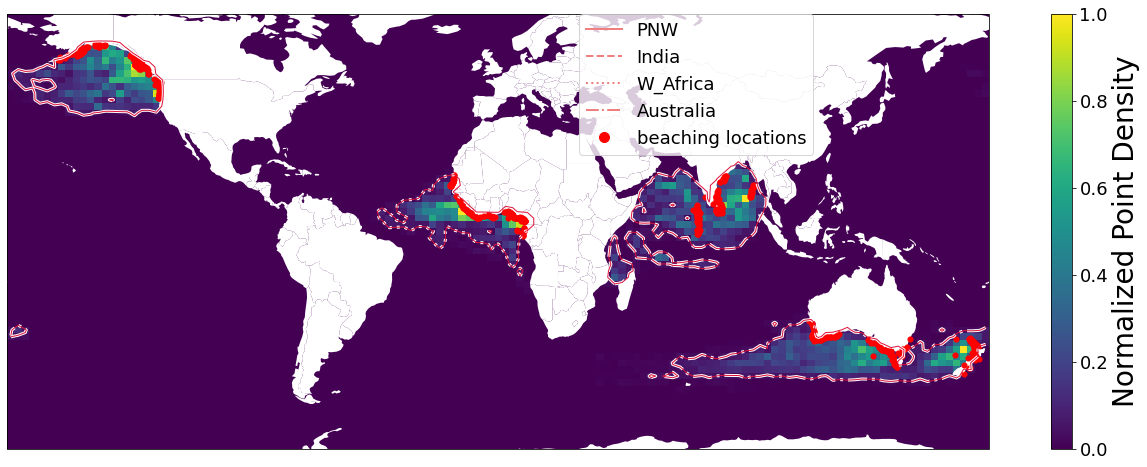

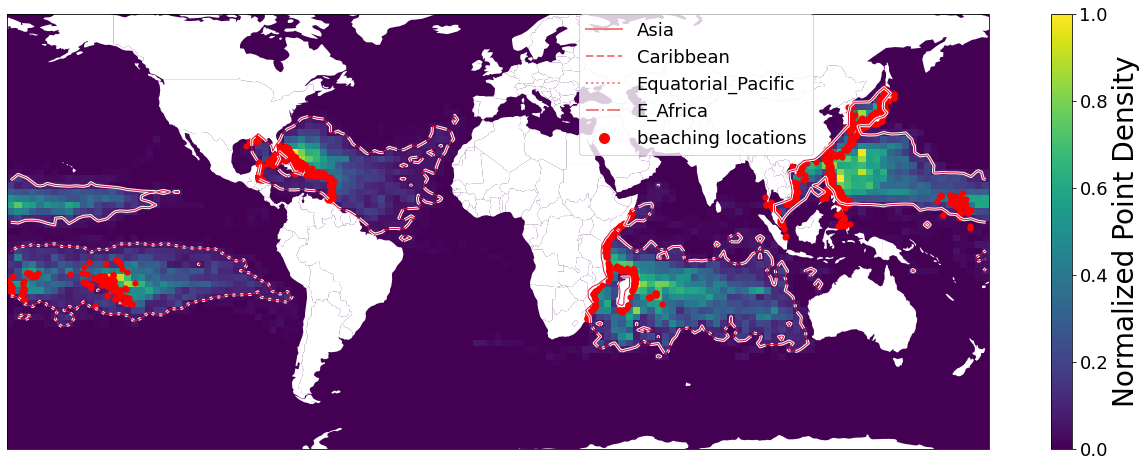

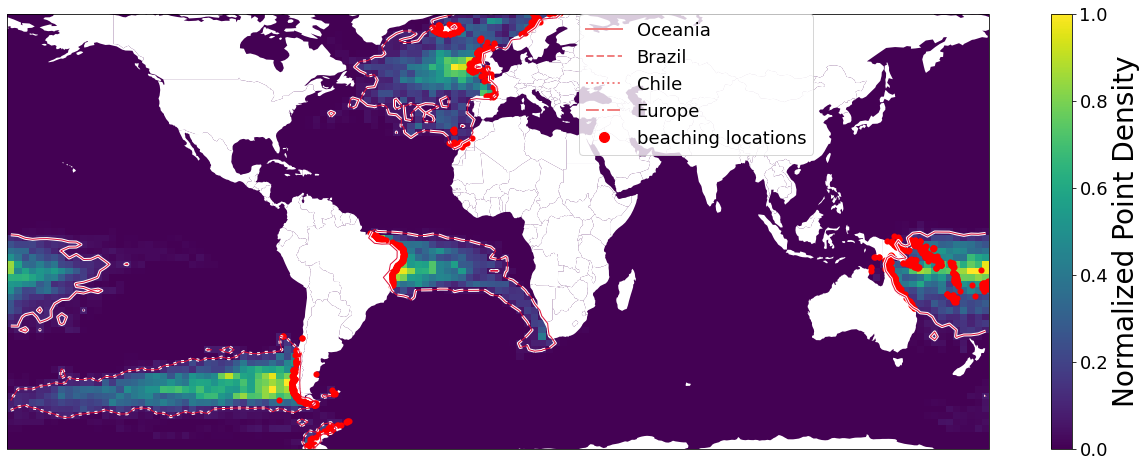

In [105]:
# Load world shapefile once
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

# Define the grid for the heatmap
n_lons, n_lats = 135, 85  # Number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)
lon_centers_cluster = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers_cluster = (lat_bins[1:] + lat_bins[:-1]) / 2

# New function to filter data to within 1 year
def year_to_beach(cluster):
    year = 31536000  # Number of seconds in 1 year
    # Make a copy of the filtered cluster to avoid the warning
    if (cluster['time_to_beach'] <= year).any():
        filtered_cluster = cluster[cluster['time_to_beach'] <= year].copy()
    return filtered_cluster

def preprocess_data(df):
    # Ensure df is modified safely with .loc and make a copy if needed
    df.loc[:, 'lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df.loc[:, 'lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df.dropna(subset=['lat', 'lon'], inplace=True)
    
    return df

def process_watersheds(watershed_names, watersheds):
    # Create a figure for the plot
    fig = plt.figure(figsize=(22, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
    
    # Adjust the position of the plot box for better width control
   # ax.set_position([0.05, 0.05, 0.9, 0.9])  # [left, bottom, width, height]

    cmap = plt.cm.get_cmap("viridis").copy()
    
    contour_handles = []
    
    heatmap_data_normalized12_list = np.zeros((85, 135))
    for j, watershed_name in enumerate(watershed_names):
        # Filter the data for 1 year (12 months) using the new function
        filtered_data_12m = preprocess_data(year_to_beach(watersheds[watershed_name]))
       # print(filtered_data_12m)
        
        latitudes12 = list(filtered_data_12m['lat'].values)
        longitudes12 = list(filtered_data_12m['lon'].values)

        # Calculate the 2D histogram (density plot) of point density for 12 months
        heatmap_data12, _, _ = np.histogram2d(latitudes12, longitudes12, bins=[lat_bins, lon_bins], density=True)

        # Normalize the 12-month data
        heatmap_data_normalized12 = (heatmap_data12 - np.min(heatmap_data12)) / (np.max(heatmap_data12) - np.min(heatmap_data12))

        # Plot contours for the normalized data
        linewidths = [3]
        linestyless = ['-', '--', ':', '-.']
        contour = plt.contour(
            lon_centers_cluster, lat_centers_cluster, heatmap_data_normalized12,
            levels=[np.mean(heatmap_data_normalized12) + np.std(heatmap_data_normalized12)], 
            colors='white', linestyles=linestyless[j], linewidths=linewidths[0], 
            transform=ccrs.PlateCarree()
        )
        contour_handles.append(contour.collections[0])
        
        # Add additional contour with crimson color
        contour = plt.contour(
            lon_centers_cluster, lat_centers_cluster, heatmap_data_normalized12,
            levels=[np.mean(heatmap_data_normalized12) + np.std(heatmap_data_normalized12)],
            colors='crimson', linestyles='solid', linewidths=1,
            transform=ccrs.PlateCarree()
        )
        contour_handles.append(contour.collections[0])

        heatmap_data_normalized12_list += heatmap_data_normalized12
    # Plot the filled contour for normalized heatmaps
    mesh = ax.pcolormesh(lon_centers_cluster, lat_centers_cluster, heatmap_data_normalized12_list, cmap=cmap, transform=ccrs.PlateCarree())

    # Plot the land polygons
    land.plot(ax=ax, color='white', edgecolor='none')
    Antarctica.plot(ax=ax, color='white', edgecolor='none')

    # Plot legend
    contour_handles = [
        Line2D([0], [0], color='lightcoral', linestyle=linestyle, linewidth=2)
        for linestyle in linestyless
    ]

    for watershed_name in watershed_names:
        plt.scatter(beaching_dict[watershed_name]['lon'], beaching_dict[watershed_name]['lat'], 
                    color='red', linewidth=0.1)

    beach_coords_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='beach coords')

    ax.legend(contour_handles + [beach_coords_handle], watershed_names + ['beaching locations'], loc='upper right', bbox_to_anchor=(0.83, 1.02), fontsize=18)

    # Add colorbar with increased tick size and label text size
    cbar = plt.colorbar(mesh, label='Normalized Point Density')
    cbar.ax.tick_params(labelsize=18)  # Increase tick size
    cbar.set_label('Normalized Point Density', size=28)  # Increase label text size
    ax.set_aspect('auto')
    
    plt.savefig(f"final_watersheds/watersheds_{'_'.join(watershed_names)}.png")
    
    
# Define combinations of watersheds
combinations = [
    (['PNW', 'India', 'W_Africa', 'Australia'], watersheds),
    (['Asia', 'Caribbean', 'Equatorial_Pacific', 'E_Africa'], watersheds),
    (['Oceania', 'Brazil', 'Chile', 'Europe'], watersheds),
]

for watershed_names, watersheds in combinations:
    process_watersheds(watershed_names, watersheds)


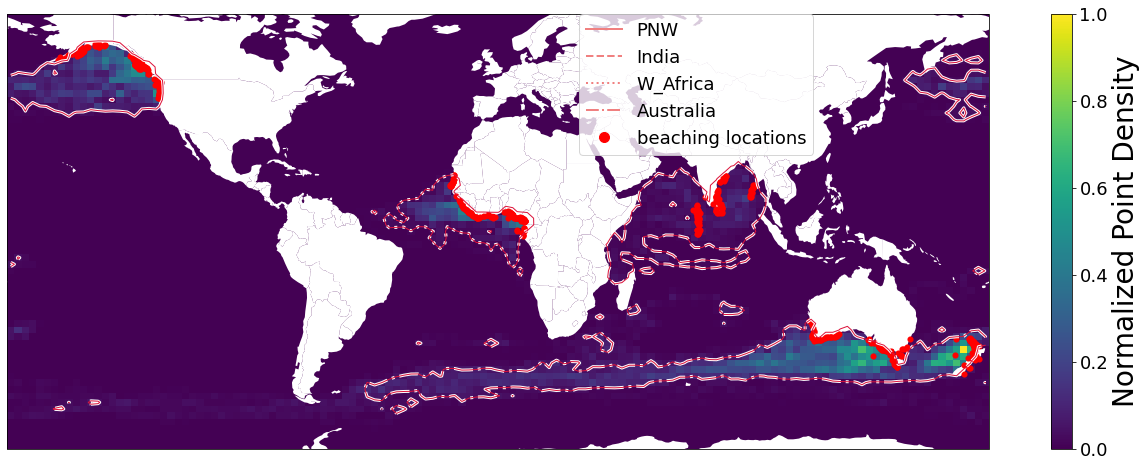

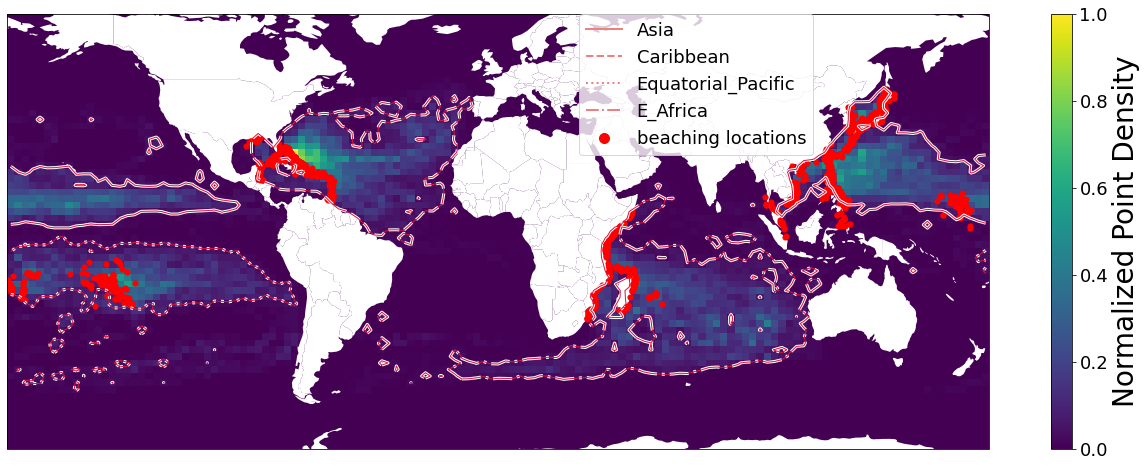

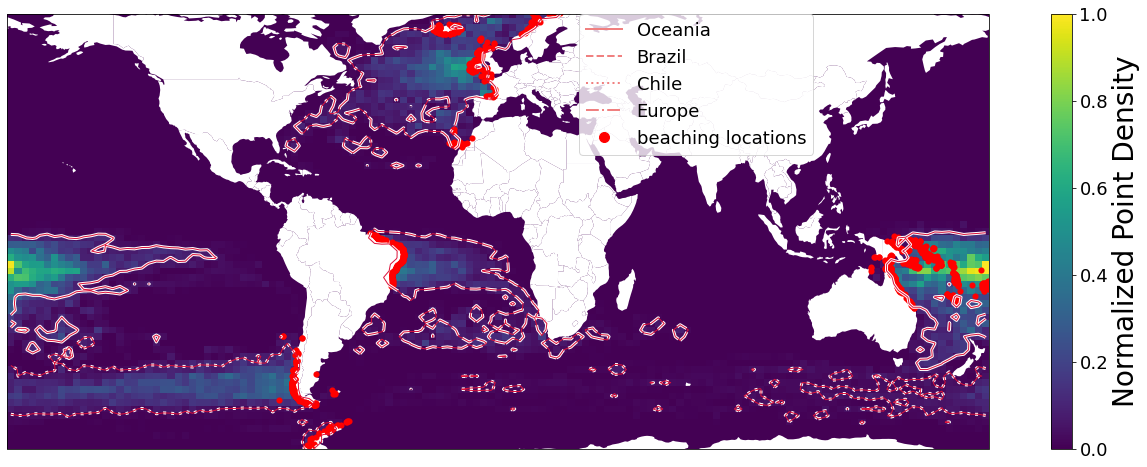

In [25]:
# Load world shapefile once
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

# Define the grid for the heatmap
n_lons, n_lats = 135, 85  # Number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)
lon_centers_cluster = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers_cluster = (lat_bins[1:] + lat_bins[:-1]) / 2
def process_watersheds(watershed_names, watersheds):
    # Create a figure for the plot
    fig = plt.figure(figsize=(22, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())

    cmap = plt.cm.get_cmap("viridis").copy()
    
    heatmaps = {period: np.zeros((n_lats, n_lons)) for period in ['full', '12m', '6m', '3m', '1m']}
    contour_handles = []
    for watershed_name in watershed_names:
        ids = watersheds[watershed_name]
        # Filter data for the watershed
        mask = beach['id'].isin(ids)
        filtered_watershed_data = beach[mask]

        # Calculate the latest_time for the current watershed
        latest_time = filtered_watershed_data['time_to_beach'].max()



        time_thresholds = {
            'full': latest_time - 1555200000000000000,  # Full time range
            '12m': latest_time - 31536000,         # 12 months
            '6m': latest_time - 15552000,          # 6 months
            '3m': latest_time - 7890000,           # 3 months
            '1m': latest_time - 2629800            # 1 month
        }

         # Collect latitude and longitude data for the heatmaps
        latitudes, longitudes = {}, {}
        for period, start_time in time_thresholds.items():
            period_filtered_data = filtered_watershed_data[filtered_watershed_data['time_to_beach'] >= start_time]
            latitudes[period] = period_filtered_data['lat'].values
            longitudes[period] = period_filtered_data['lon'].values

            # Update heatmaps with the watershed data
            heatmap_data = histogram2d(latitudes[period], longitudes[period], bins=[n_lats, n_lons], range=[[-90, 90], [-180, 180]])
            heatmaps[period] += heatmap_data
    
    # Normalize the data to be in the range [0, 1]
    for period in heatmaps.keys():
        heatmaps[period] = (heatmaps[period] - np.min(heatmaps[period])) / (np.max(heatmaps[period]) - np.min(heatmaps[period]))

    linestyless = ['-', '--',':','-.']
    for j, watershed_name in enumerate(watershed_names):
        ids = watersheds[watershed_name]
        # Filter data for the watershed
        mask = beach['id'].isin(ids)
        filtered_watershed_data = beach[mask]
        
        latitudes = []
        longitudes = []
        latitudes12 = []
        longitudes12 = []
        
        # Group by 'id' and compute the latest_time for each trajectory in one step
        latest_times = filtered_watershed_data.groupby('id')['time_to_beach'].transform('max')

        # Compute start_time and start_time12 for each trajectory (for all rows in one step)
        start_times = latest_times - 15552000000000  # Full
        start_times12 = latest_times - 31536000  # 12m

        # Filter data for the 'latest_time' <= 'time_to_beach'
        latest_data_all = filtered_watershed_data[filtered_watershed_data['time_to_beach'] <= latest_times]

        # Filter for the full and 12-month time ranges using boolean indexing
        latest_data = latest_data_all[latest_data_all['time_to_beach'] >= start_times]
        latest_data12 = latest_data_all[latest_data_all['time_to_beach'] >= start_times12]

        # Append the latitude and longitude lists in one step
        latitudes += list(latest_data['lat'].values)
        longitudes += list(latest_data['lon'].values)

        latitudes12 += list(latest_data12['lat'].values)
        longitudes12 += list(latest_data12['lon'].values)

        # Calculate the 2D histogram (density plot) of point density
        heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

        # Normalize the data to be in the range [0, 1]
        heatmap_data_normalized_cluster = (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

        lon_centers_cluster = (lon_bins[1:] + lon_bins[:-1]) / 2
        lat_centers_cluster = (lat_bins[1:] + lat_bins[:-1]) / 2

        # append to previous clusters
        heatmap_data_normalized = (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))


        ###12

        # Calculate the 2D histogram (density plot) of point density
        heatmap_data12, _, _ = np.histogram2d(latitudes12, longitudes12, bins=[lat_bins, lon_bins], density=True)

        # Normalize the data to be in the range [0, 1]
        heatmap_data_normalized12 = (heatmap_data12 - np.min(heatmap_data12)) / (np.max(heatmap_data12) - np.min(heatmap_data12))

        
        
        linewidths = [3]
        for data_normalized, linewidth in zip([heatmap_data_normalized12], linewidths):
            # Add contour lines at the specified level (0.05 in this case)
            contour = plt.contour(lon_centers_cluster, lat_centers_cluster, data_normalized, levels=[np.mean(data_normalized) + np.std(data_normalized)], colors='white', linestyles=linestyless[j], linewidths=linewidth, transform=ccrs.PlateCarree())
        linewidths = [1]
        for data_normalized, linewidth in zip([heatmap_data_normalized12], linewidths):
            # Add contour lines at the specified level (0.05 in this case)
            
            contour = plt.contour(lon_centers_cluster, lat_centers_cluster, data_normalized, levels=[np.mean(data_normalized)+ np.std(data_normalized)], colors='crimson', linestyles='solid', linewidths=linewidth, transform=ccrs.PlateCarree())

        contour_handles.append(contour.collections[0])
        

        
    # Plot the filled contour for normalized heatmap (full time range)
    mesh = ax.pcolormesh(lon_centers_cluster, lat_centers_cluster, heatmaps['full'], cmap=cmap, transform=ccrs.PlateCarree())

    # Plot the land polygons
    land.plot(ax=ax, color='white', edgecolor='none')
    Antarctica.plot(ax=ax, color='white', edgecolor='none')
    
    # Add colorbar with increased tick size and label text size
    cbar = plt.colorbar(mesh, label='Normalized Point Density')
    cbar.ax.tick_params(labelsize=18)  # Increase tick size
    cbar.set_label('Normalized Point Density', size=28)  # Increase label text size
    ax.set_aspect('auto')

    contour_handles = [
    Line2D([0], [0], color='lightcoral', linestyle=linestyle, linewidth=2)  # Customize color, linewidth as needed
    for linestyle in linestyless]


 
    
    for watershed_name in watershed_names:
        plt.scatter(beaching_dict[watershed_name]['lon'],beaching_dict[watershed_name]['lat'], 
                    color = 'red', linewidth = 0.1)

    beach_coords_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='beach coords')

    ax.legend(contour_handles + [beach_coords_handle], watershed_names + ['beaching locations'], loc='upper right', bbox_to_anchor=(0.83, 1.02), fontsize=18)


    # plt.title(f'Watersheds: {", ".join(watershed_names)}')
#    plt.savefig(f"watersheds_{'_'.join(watershed_names)}.png")
    # plt.close(fig)

# Define combinations of watersheds
combinations = [
    (['PNW', 'India', 'W_Africa', 'Australia'], watersheds),
    (['Asia', 'Caribbean', 'Equatorial_Pacific','E_Africa'], watersheds),
    (['Oceania', 'Brazil', 'Chile','Europe'], watersheds),]
#combinations = [(['Alaska', 'India', 'W_Africa','Asia', 'Australia', 
#                  'Equatorial_Pacific','East_Indies', 'E_Africa', 'Caribbean',
#                 'Europe', 'S_S_America', 'Brazil'],watersheds)]

for watershed_names, watersheds in combinations:
    process_watersheds(watershed_names, watersheds)

In [26]:
centroid_dict

{'PNW': (53.499427342657334, -137.4473823776225),
 'India': (8.567247102803737, 79.72656607476635),
 'W_Africa': (6.591116690647479, -2.747436834532374),
 'Australia': (-37.34967290123457, 146.88767864197536),
 'Asia': (20.109046112956825, 129.01474906976753),
 'Caribbean': (21.16305893258426, -74.48243587078645),
 'Equatorial_Pacific': (-17.26579095238094, -153.58165956709965),
 'E_Africa': (-10.418899558823526, 43.3386380882353),
 'Oceania': (-11.87457875354107, 156.58729929178472),
 'Brazil': (-8.0876602739726, -38.524937808219185),
 'Chile': (-52.63800658385093, -70.98986795031055),
 'Europe': (54.835702901960794, -6.4079433725490205)}

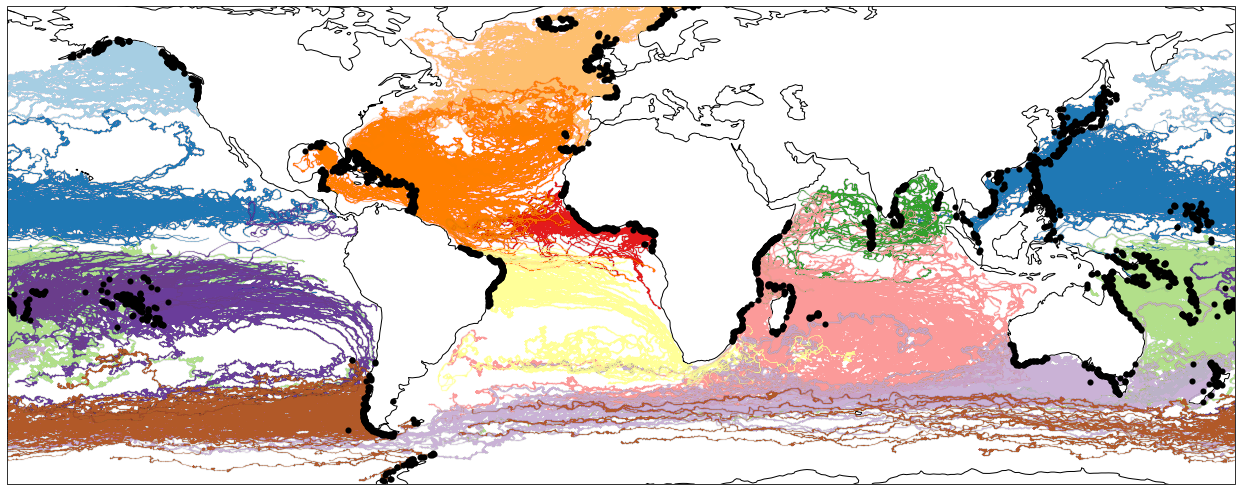

In [48]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

paired_cmap = plt.get_cmap('Paired')
colors = paired_cmap(np.linspace(0, 1, 12))

watershed_colors = {str(w): colors[i] for i, w in enumerate(watersheds)}

# Scatter plot with colors based on HDBSCAN labels
for watershed in watersheds:
    color_indice = watershed_colors[str(watershed)]
    scatter1 = plt.scatter(
        beach[beach['id'].isin(watersheds[str(watershed)])]['lon'],
        beach[beach['id'].isin(watersheds[str(watershed)])]['lat'],
        marker='o',
        color=color_indice,
        alpha=0.7,
        s=0.001)
    
#plt.scatter(beaching_coooords[1], beaching_coooords[0], color = 'r', linewidth = 0.01)

for centroid in beaching_dict:
    plt.scatter(beaching_dict[centroid]['lon'],beaching_dict[centroid]['lat'], 
                color = 'k', linewidth = 0.1)
    


# Get the colors used in the first figure

#ax.legend()
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.title('selected clusters')


plt.savefig("trajectories")
#plt.close(fig)
plt.show()